# Load simulation data

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
    
from common.read_COMSOL_data import *

In [2]:
CURR_PATH = os.getcwd()
DATA_PATH = os.path.join(CURR_PATH, 'data')

For sample

In [3]:
file_path_sample_2d = os.path.join(DATA_PATH, '20171022_lfo_sim_data_2d.csv')
data_sample_2d = read_COMSOL_csv(file_path_sample_2d, name_list=['tip_curv', 'cdt', 'freq', 'y21_imag', 'y21_real'])
file_path_sample = os.path.join(DATA_PATH, '20171022_lfo_sim_data_3d.csv')
data_sample = read_COMSOL_csv(file_path_sample, name_list=['tip_curv', 'cdt', 'freq', 'y21_imag', 'y21_real'])

In [4]:
data_sample.head()

,tip_curv,cdt,freq,y21_imag,y21_real
0,100,0.010000,1000000000,-432.868977,-0.492277
1,100,0.017783,1000000000,-432.877769,-0.875274
2,100,0.031623,1000000000,-432.905554,-1.555739
3,100,0.056234,1000000000,-432.993235,-2.762374
4,100,0.100000,1000000000,-433.268697,-4.889010


In [5]:
tip_curv = 300
freq = 1e9
conditions= {'tip_curv': tip_curv, 'freq': freq}
sub_sample_2d = get_sub_dataframe(data_sample_2d, conditions=conditions)
sub_sample = get_sub_dataframe(data_sample, conditions=conditions)

In [6]:
cdt = sub_sample['cdt'].values
imag = -1 * sub_sample['y21_imag'].values
real = -1 * sub_sample['y21_real'].values
cdt_2d = sub_sample_2d['cdt'].values
imag_2d = -1 * sub_sample_2d['y21_imag'].values
real_2d = -1 * sub_sample_2d['y21_real'].values

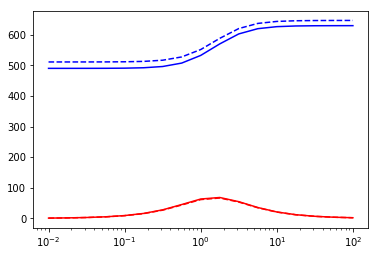

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(cdt, imag, 'b-', cdt, real, 'r-')
plt.plot(cdt_2d, imag_2d, 'b--', cdt_2d, real_2d, 'r--')
plt.xscale('log')

Minor difference between 2d and 3d simulation.

# Interpolate curves for imag & real

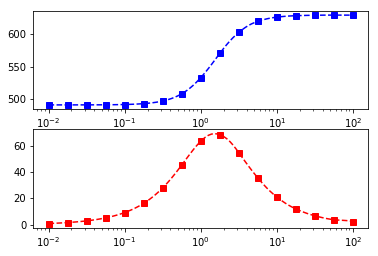

In [8]:
from scipy.interpolate import InterpolatedUnivariateSpline
curve_imag = InterpolatedUnivariateSpline(cdt, imag)
curve_real = InterpolatedUnivariateSpline(cdt, real)
xs = numpy.logspace(-2, 2, 100)

plt.subplot(2, 1, 1)
plt.plot(xs, curve_imag(xs), 'b--')
plt.plot(cdt, imag, 'bs')
plt.xscale('log')

plt.subplot(2, 1, 2)
plt.plot(xs, curve_real(xs), 'r--')
plt.plot(cdt, real, 'rs')
plt.xscale('log')

In [9]:
def get_delta_y(avg_x, delta_x, curve):
    x1 = avg_x - 0.5 * delta_x
    x2 = avg_x + 0.5 * delta_x
    delta_y = curve(x2) - curve(x1)
    return delta_y

In [10]:
get_delta_y(1, 0.1, curve_real)

2.4959222767275264

# Estimation of domain1/2 cdt at different bias

In [11]:
import pandas
file_path = os.path.join(DATA_PATH, '20171020_d1d2_cdt_estimation3.csv')
data = pandas.read_csv(file_path, names=['bias', 'imag', 'real'])

In [12]:
# scaling_factor 4.4 (3.5mV for 1nS at -20dBm => 4.4mV for 1nS at -18dBm)
def search_d1d2_cdt(avg_cdt, search_range, mim_delta_imag, mim_delta_real, signal_scaling_factor=4.4):
    cdt_range = numpy.linspace(search_range[0] * avg_cdt, search_range[1] * avg_cdt, 1000)
    delta_imag = mim_delta_imag / signal_scaling_factor
    delta_real = mim_delta_real / signal_scaling_factor
    
    best_cdt1 = 0
    best_cdt2 = 0

    err_sqr_sum = 999
    for cdt1 in cdt_range:
        for cdt2 in cdt_range:
            delta_imag_new = curve_imag(cdt1) - curve_imag(cdt2)
            delta_real_new = curve_real(cdt1) - curve_real(cdt2)
            new_err_sqr_sum = (delta_imag_new - delta_imag) ** 2 + (delta_real_new - delta_real) ** 2
            if new_err_sqr_sum < err_sqr_sum:
                best_cdt1 = cdt1
                best_cdt2 = cdt2
                err_sqr_sum = new_err_sqr_sum
    print "Best fit cdt1: {} S/m, cdt2: {} S/m, error: {}".format(best_cdt1, best_cdt2, err_sqr_sum)
    print "[Delta Imag] Experiment: {}nS, Simulation: {}nS".format(delta_imag, curve_imag(best_cdt1) - curve_imag(best_cdt2))
    print "[Delta Real] Experiment: {}nS, Simulation: {}nS".format(delta_real, curve_real(best_cdt1) - curve_real(best_cdt2))
    return (best_cdt1, best_cdt2)

In [22]:
some_bias = 3
some_data = data[data['bias'] == some_bias]
some_imag = some_data['imag'].values[0]
some_real = some_data['real'].values[0]
(data.loc[0, 'cdt1'], data.loc[0, 'cdt2']) = search_d1d2_cdt(0.1, (0.1, 10), some_imag, some_real)

Best fit cdt1: 1.0 S/m, cdt2: 0.882072072072 S/m, error: 4.87946590153
[Delta Imag] Experiment: 7.94545454545nS, Simulation: 6.8599142654nS
[Delta Real] Experiment: 1.48863636364nS, Simulation: 3.41245241563nS


In [14]:
some_bias = 2
some_data = data[data['bias'] == some_bias]
some_imag = some_data['imag'].values[0]
some_real = some_data['real'].values[0]
(data.loc[1, 'cdt1'], data.loc[1, 'cdt2']) = search_d1d2_cdt(1, (0.1, 3), some_imag, some_real)

Best fit cdt1: 1.48468468468 S/m, cdt2: 1.44114114114 S/m, error: 4.14558859066e-05
[Delta Imag] Experiment: 2.02954545455nS, Simulation: 2.03526444089nS
[Delta Real] Experiment: 0.0909090909091nS, Simulation: 0.0879512063393nS


In [15]:
some_bias = 1
some_data = data[data['bias'] == some_bias]
some_imag = some_data['imag'].values[0]
some_real = some_data['real'].values[0]
(data.loc[2, 'cdt1'], data.loc[2, 'cdt2']) = search_d1d2_cdt(1, (0.1, 3), some_imag, some_real)

Best fit cdt1: 1.38888888889 S/m, cdt2: 1.37727727728 S/m, error: 0.000321827001834
[Delta Imag] Experiment: 0.55nS, Simulation: 0.565616562707nS
[Delta Real] Experiment: 0.0659090909091nS, Simulation: 0.0570801628278nS


In [16]:
some_bias = 0
some_data = data[data['bias'] == some_bias]
some_imag = some_data['imag'].values[0]
some_real = some_data['real'].values[0]
(data.loc[3, 'cdt1'], data.loc[3, 'cdt2']) = search_d1d2_cdt(1, (0.1, 3), some_imag, some_real)

Best fit cdt1: 0.970870870871 S/m, cdt2: 0.965065065065 S/m, error: 0.000456893058793
[Delta Imag] Experiment: 0.356818181818nS, Simulation: 0.335996367608nS
[Delta Real] Experiment: 0.152272727273nS, Simulation: 0.15710440522nS


In [17]:
some_bias = -1
some_data = data[data['bias'] == some_bias]
some_imag = some_data['imag'].values[0]
some_real = some_data['real'].values[0]
(data.loc[4, 'cdt1'], data.loc[4, 'cdt2']) = search_d1d2_cdt(1, (0.1, 3), some_imag, some_real)

Best fit cdt1: 0.358358358358 S/m, cdt2: 0.372872872873 S/m, error: 0.0143828506451
[Delta Imag] Experiment: -0.506818181818nS, Simulation: -0.589303329384nS
[Delta Real] Experiment: -1.02272727273nS, Simulation: -1.10978501837nS


In [18]:
some_bias = -2
some_data = data[data['bias'] == some_bias]
some_imag = some_data['imag'].values[0]
some_real = some_data['real'].values[0]
(data.loc[5, 'cdt1'], data.loc[5, 'cdt2']) = search_d1d2_cdt(1, (0.1, 3), some_imag, some_real)

Best fit cdt1: 0.332232232232 S/m, cdt2: 0.364164164164 S/m, error: 0.00259728636158
[Delta Imag] Experiment: -1.21363636364nS, Simulation: -1.2493798216nS
[Delta Real] Experiment: -2.44772727273nS, Simulation: -2.48405483216nS


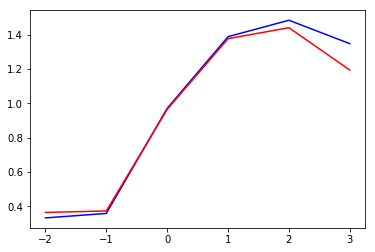

In [19]:
plt.plot(data['bias'].values, data['cdt1'].values, 'b-')
plt.plot(data['bias'].values, data['cdt2'].values, 'r-')

In [20]:
data.to_csv(os.path.join(DATA_PATH, "20171022_d1d2_cdt_vs_bias_result.csv"), index=False)

In [21]:
data

,bias,imag,real,cdt1,cdt2
0,3,34.96,6.55,1.348248,1.194394
1,2,8.93,0.40,1.484685,1.441141
2,1,2.42,0.29,1.388889,1.377277
3,0,1.57,0.67,0.970871,0.965065
4,-1,-2.23,-4.50,0.358358,0.372873
5,-2,-5.34,-10.77,0.332232,0.364164
